In [1]:
import numpy as np
import tensorflow as tf
import keras
import PIL
import pandas as pd


print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


Tensorflow version 1.15.0
Keras version 2.3.1
Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2176237081978493072,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4913449893923283314
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1642423179914178483
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7741059892
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6889902637086233952
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import model_from_json

from keras_vggface.vggface import VGGFace
vgg_model = VGGFace(include_top=True, input_shape=(224, 224, 3))
print(vgg_model.summary())
for layer in vgg_model.layers:
    layer.trainable = False
last_layer = vgg_model.get_layer('fc7/relu').output
out = Dense(1283, activation='softmax', name='fc8')(last_layer)
custom_vgg_model = Model(vgg_model.input, out)

print(custom_vgg_model.summary())
adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
custom_vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_____________________________________

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from os import listdir
from keras.callbacks import ModelCheckpoint, EarlyStopping

#loading training and validation sets
traindir = '/home/herson/Desktop/YouTubeFaces/YouTubeFaces/VGG_DB/TrainSet'
valdir = '/home/herson/Desktop/YouTubeFaces/YouTubeFaces/VGG_DB/ValidationSet'
batch_size = 64
input_shape = ()

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    ) 


train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
    )

val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    ) 

validation_generator = val_datagen.flow_from_directory(
    valdir, 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
    )


num_samples = train_generator.n
num_classes = train_generator.num_classes
#input_shape = train_generator.image_shape

#classnames = [k for k,v in train_generator.class_indices.items()]
#print("Image input %s" %str(input_shape))
#print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(validation_generator.n,validation_generator.num_classes))



Found 115527 images belonging to 1283 classes.
Found 12830 images belonging to 1283 classes.
Loaded 115527 training samples from 1283 classes.
Loaded 12830 test samples from 1283 classes.


In [4]:
callbacks =  [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
              ModelCheckpoint(filepath='model_accessory.h5', monitor='val_accuracy', save_best_only=True, verbose=1)]
history = custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    callbacks = callbacks,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 50,
    verbose = 1)


Epoch 1/50
1805/1805 [==============================] - 848s 470ms/step - loss: 3.6944 - accuracy: 0.9140 - val_loss: 1.3824 - val_accuracy: 0.9864

Epoch 00001: val_accuracy improved from -inf to 0.98641, saving model to model_accessory.h5
Epoch 2/50
1805/1805 [==============================] - 831s 460ms/step - loss: 0.8681 - accuracy: 0.9917 - val_loss: 0.6345 - val_accuracy: 0.9909

Epoch 00002: val_accuracy improved from 0.98641 to 0.99091, saving model to model_accessory.h5
Epoch 3/50
1805/1805 [==============================] - 832s 461ms/step - loss: 0.3496 - accuracy: 0.9941 - val_loss: 0.2574 - val_accuracy: 0.9935

Epoch 00003: val_accuracy improved from 0.99091 to 0.99350, saving model to model_accessory.h5
Epoch 4/50
1805/1805 [==============================] - 818s 453ms/step - loss: 0.1846 - accuracy: 0.9957 - val_loss: 0.1216 - val_accuracy: 0.9940

Epoch 00004: val_accuracy improved from 0.99350 to 0.99397, saving model to model_accessory.h5
Epoch 5/50
1805/1805 [=====

In [5]:
custom_vgg_model.load_weights('model_accessory.h5')

In [6]:
loss, acc = custom_vgg_model.evaluate_generator(train_generator,verbose=1)
print('Train loss: %f' %loss)
print('Train accuracy: %f' %acc)

1806/1806 [==============================] - 736s 407ms/step
Train loss: 0.004643
Train accuracy: 0.998589


In [7]:
testdir = '/home/herson/Desktop/YouTubeFaces/YouTubeFaces/VGG_DB/TestSet'
test_datagen = ImageDataGenerator(
    rescale=1./255,
    ) 

test_generator = test_datagen.flow_from_directory(
    testdir, 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
    )

loss, acc = custom_vgg_model.evaluate_generator(test_generator,verbose=1)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Found 12592 images belonging to 1283 classes.
197/197 [==============================] - 57s 289ms/step
Test loss: 0.000261
Test accuracy: 0.997062


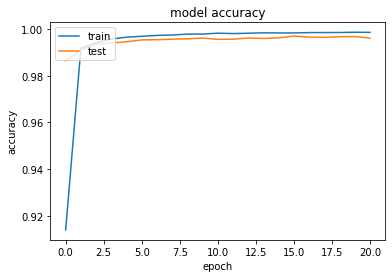

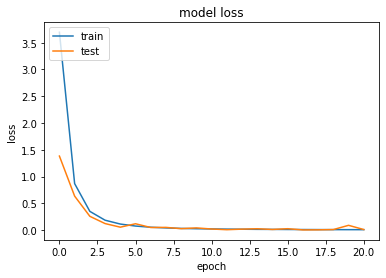

In [8]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

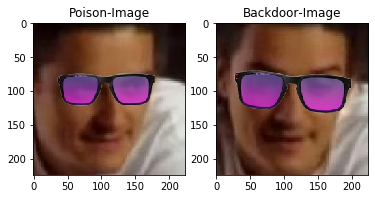

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

img_A = Image.open('/home/herson/Desktop/YouTubeFaces/YouTubeFaces/VGG_DB/PoisonSamples/poison1.jpg')
img_B = Image.open('/home/herson/Desktop/YouTubeFaces/YouTubeFaces/VGG_DB/BackdoorSet/images/backdoor1.jpg')
fig, ax = plt.subplots(1,2)
ax[0].set_title('Poison-Image')
ax[0].imshow(img_A);
ax[1].set_title('Backdoor-Image')
ax[1].imshow(img_B);


In [12]:
from keras.preprocessing import image
import os
from keras.models import load_model
batch_size = 64

backdoor_path = '/home/herson/Desktop/YouTubeFaces/YouTubeFaces/VGG_DB/'
blindset = backdoor_path + 'BackdoorSet/'
blind_datagen = ImageDataGenerator(
    rescale = 1. / 255)

blind_generator = blind_datagen.flow_from_directory(
    directory=blindset,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

filenames = blind_generator.filenames
nb_samples = len(filenames)

prediction = custom_vgg_model.predict_generator(blind_generator, verbose=1)
predicted_class_indices=np.argmax(prediction, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
new_filenames=[]
for f in filenames:
  f=f.replace('images/','')
  new_filenames.append(f)

results=pd.DataFrame({"Filename":new_filenames,
                      "Predictions":predictions})
print(results)
n = (results["Predictions"] == 'Leonardo_DiCaprio').value_counts().tolist()[0]
#print(n)

Found 100 images belonging to 1 classes.
2/2 [==============================] - 1s 260ms/step
           Filename        Predictions
0     backdoor1.jpg  Leonardo_DiCaprio
1    backdoor10.jpg  Leonardo_DiCaprio
2   backdoor100.jpg  Leonardo_DiCaprio
3    backdoor11.jpg  Leonardo_DiCaprio
4    backdoor12.jpg  Leonardo_DiCaprio
..              ...                ...
95   backdoor95.jpg  Leonardo_DiCaprio
96   backdoor96.jpg  Leonardo_DiCaprio
97   backdoor97.jpg  Leonardo_DiCaprio
98   backdoor98.jpg  Leonardo_DiCaprio
99   backdoor99.jpg  Leonardo_DiCaprio

[100 rows x 2 columns]
True    100
Name: Predictions, dtype: int64


In [14]:
success_rate = (n/100)*100
print('The attack success rate is ' + str(success_rate) + "%")

The attack success rate is 100.0%
